In [126]:
import numpy as np
from sklearn import preprocessing
from scipy.stats import multivariate_normal

import seaborn as sns
import matplotlib.pyplot as plt

In [127]:
def logsumexp(x):
    return np.log(np.sum(np.exp(x)))

# sum calculated with log sum exponential - not yet used
def sum_lse(x):
    a = np.log(x)
    return np.exp(np.max(a) + np.log(np.sum(np.exp(a-np.max(a)))))

In [128]:
def kmeans(X, K, max_iterations=1000, tolerance=0.0000000001, nrestart=10):
    N = np.shape(X)[0]
    mus = []
    zs = []
    Js = []
    for irestart in range(nrestart):
        Jold = np.inf
        rp = np.random.permutation(N)
        mu = X[rp[0:K],:]

        for i in range(max_iterations):
            distances = np.zeros((N, K))
            for k in range(K):
                distances[:, k] = np.sqrt(np.sum((X - mu[k,:])**2,1))

            z = np.argmin(distances, 1)
            mindist = np.min(distances, 1)
            J = np.sum(mindist) / N
            if J > Jold - tolerance: break
            Jold = J
            for k in range(K):
                mu[k,:] = np.mean(X[z == k,:], 0)

        mus.append(mu)
        zs.append(z)
        Js.append(J)

    min_J = min(Js)
    id = Js.index(min_J)
    mu_kmeans = mus[id]
    z_kmeans = zs[id]
    return mu_kmeans, z_kmeans

def log_normalize(X):
    (N, d) = np.shape(X)
    a = np.max(X, 1).reshape((N,1))
    X = X - np.tile(a + np.log(np.sum(np.exp(X - np.tile(a, (1, d))), 1).reshape((N,1))), (1, d))
    return X

def E_step(X, K, mus, sigmas, pis):
    (N,d) = X.shape
    logtau_unnormalized = np.zeros((N, K))
    for k in range(K):
        invSigma = np.linalg.inv(sigmas[k])
        xc = (X - np.tile(mus[k, :], (N, 1)))
        eigvalues = np.linalg.eig(sigmas[k])[0]
        logtau_unnormalized[:, k] = - 0.5 * np.sum(np.dot(xc, invSigma) * xc, 1) - 0.5 * np.sum(
            np.log(eigvalues)) - 0.5 * d * np.log(2 * np.pi) + np.log(pis[k])
    logtau = log_normalize(logtau_unnormalized)
    tau = np.exp(logtau)
    # unnormalized log_likelihood
    loglik = (- np.sum(logtau.reshape(-1) * tau.reshape(-1)) + np.sum(tau.reshape(-1) * logtau_unnormalized.reshape(-1)))
    return tau, loglik

def my_em_gaussian(X, X_test, K, max_iterations=1000, tolerance=0.0000000001):
    (N, d) = np.shape(X)
    loglikold = -np.inf
    mu_kmeans, z_kmeans = kmeans(X, K)
    mus = mu_kmeans
    sigmas = []
    for k in range(K):
        sigmas.append(np.eye(d))
    pis = 1.0 / K * np.ones((K, 1))

    for i in range(max_iterations):
        #print 'iteration ', i
        tau, loglik = E_step(X, K, mus, sigmas, pis)
        # for the test data
        tau_test, loglik_test = E_step(X_test, K, mus, sigmas, pis)
        if loglik < loglikold + tolerance: break
        loglikold = loglik
        # print 'log-likelihood: ', loglikold

        for k in range(K):
            tau_k = np.tile(tau[:, k].reshape((N, 1)), (1, d))
            mus[k,:] = np.sum(tau_k * X, 0) / np.sum(tau[:, k])
            pis[k] = 1.0 / N * np.sum(tau[:, k])
            temp = X - np.tile(mus[k,:], (N, 1))
            sigmas[k] = 1.0 / np.sum(tau[:, k]) * np.dot(np.transpose(temp), (tau_k * temp))

    return pis, mus, sigmas, loglik, loglik_test, tau


# Alpha recursion


In [129]:
## alpha recursion
# A is the transition matrix
# pi the initial probability distribution
# mu & sigma the parameters of the normal
# mu is a matrix of K rows and 2 columns
# sigma is a list of K covariance matrices
# compute_logalpha returns a (T,K) matrix
def compute_logalpha(U, A, pi, mu, sigma):
    (T,d) = U.shape
    K = len(pi) # number of classes
    logalpha = np.zeros((T,K))

    # first alpha is computed with initial proba distribution
    for k in range(0,K):
        mvnU = multivariate_normal.pdf(U[0,:], mean=mu[k,:], cov=sigma[k])
        logalpha[0,k] = np.log(pi[k]) + np.log(mvnU)

    for t in range(1,T):
        for k in range(0,K):
            # We create for each k the vector a such that:
            # a[i]=log(p(qt=k|q(t-1)=i))+log(alpha(q(t-1)=i))
            # k corresponds to the current state (t)
            # i corresponds to the previous state (t-1)
            a = logalpha[t-1,:] + np.log(A[k,:])
            mvnU = multivariate_normal.pdf(U[t,:], mean=mu[k,:], cov=sigma[k])
            logalpha[t,k] = np.log(mvnU) + np.max(a) + logsumexp(a-np.max(a))

    return logalpha


# Beta recursion

In [130]:
def compute_logbeta(U, A, pi, mu, sigma):
    (T,d) = U.shape
    K = len(pi) # number of classes
    logbeta = np.zeros((T,K))

    # The last beta is given by the vector (1,1,1,1)
    logbeta[T-1,:] = np.log(np.ones((1,K)))

    # The other are computed with the recursive formula
    # We fill our matrix logbeta row by row
    for t in range(T-2,-1,-1):
        for k in range(0,K):
            # We create for each k the vector a such that:
            # a[i]=log(beta(q(t+1)=i))+log(p(q(t+1)=i|q(t)=k))+log(p(u(t+1)|q(t+1)=i))
            # k corresponds to the current state q(t)
            # i corresponds to the following state q(t+1)
            a = np.zeros(K)
            for i in range(0,K):
                mvnU = multivariate_normal.pdf(U[t+1,:], mean=mu[i,:], cov=sigma[i])
                a[i] = logbeta[t+1,i] + np.log(A[i,k]) + np.log(mvnU)
            logbeta[t,k] = np.max(a) + logsumexp(a-np.max(a))

    return logbeta

In [131]:
def compute_log_likelihood(logbeta, logalpha):
    # We take for example q_0 to compute the probability by marginalization
    a = (logalpha + logbeta)[0, :]
    log_likelihood = np.max(a) + logsumexp(a - np.max(a))
    return log_likelihood




# Smoothing

In [132]:
def smoothing(logbeta, logalpha):
    log_nom = logbeta + logalpha
    log_denom = compute_log_likelihood(logbeta, logalpha)
    return np.exp(log_nom-log_denom)

# Joint proba

In [133]:
def compute_joint_prob(logbeta, logalpha, U, mu, sigma):
    (n,K) = logalpha.shape
    proba = np.zeros((n-1,K,K))
    log_denom = compute_log_likelihood(logbeta, logalpha)

    for t in range(0,n-1):
        # calculate the log_denominator term with log-sum-exp trick
        log_prob_t = np.zeros((K,K))
        # i loops over values taken by q_t+1
        for i in range(K):
            mvnU = multivariate_normal.pdf(U[t+1,:], mean=mu[i,:], cov=sigma[i])
            # j loops over values taken by q_t
            for j in range(K):
                log_prob_t[i,j] = logalpha[t, j] + logbeta[t + 1, i] + np.log(A[i, j]) + np.log(mvnU)
        proba[t] = np.exp(log_prob_t - log_denom)

    return proba

# EM  for HMM

In [134]:
def em_hmm(U, V, K, A, pis, mus, sigmas, max_iterations=1000, tolerance=10e-6):
    (T,d) = U.shape
    old_log_likelihood = -np.inf
    log_likelihood = []
    log_likelihood_test = []
    for step in range(max_iterations):
        # E - step
        logalpha = compute_logalpha(U, A, pis, mus, sigmas)
        logbeta = compute_logbeta(U, A, pis, mus, sigmas)

        tau = smoothing(logbeta, logalpha)
        tau_transition = compute_joint_prob(logbeta, logalpha, U, mus, sigmas)
        # At each t
        # the rows of tau_transition[t,:,:] are for q_t+1
        # the columns are for q_t

        # log-likelihood
        log_likelihood.append(compute_log_likelihood(logbeta, logalpha))
        # print 'step ', step, ' ', log_likelihood[-1]
        # We compute the log_likelihood for the test data
        logalpha_test = compute_logalpha(V, A, pis, mus, sigmas)
        logbeta_test = compute_logbeta(V, A, pis, mus, sigmas)
        log_likelihood_test.append(compute_log_likelihood(logbeta_test, logalpha_test))

        if np.abs(log_likelihood[-1] - old_log_likelihood) < tolerance:
            break
        old_log_likelihood = log_likelihood[-1]

        # M - step
        # We update pi
        pis = tau[0,:]
        sum_tau = np.sum(tau, axis=0).reshape((K,1))
        sum_tau_transition = np.sum(tau_transition, axis=0)
        # We update A
        for i in range(K): #i loops for q_t+1
            for j in range(K): #j loops for q_t
                A[i,j] = sum_tau_transition[i,j] / sum_tau[j]
            # We update mus
            tau_u = np.dot(tau[:,i], U)
            mus[i,:] = tau_u / sum_tau[i]
            # We update sigmas
            U_centered = U - mus[i,:]
            sigmas[i] = np.zeros((d,d))
            for t in range(T):
                Uc_t = U_centered[t,:].reshape((d,1))
                covariance = np.dot(Uc_t, Uc_t.T)
                sigmas[i] += tau[t,i]*covariance
            sigmas[i] = sigmas[i] / sum_tau[i]

    return A, pis, mus, sigmas, tau, log_likelihood, log_likelihood_test

# Viterbi

In [135]:
def viterbi(U,A,pi,mu,sigma):
    (T,d) = U.shape
    K = len(pi)
    V = np.zeros((T,K))

    # Initialise
    for k in range(0,K):
        mvnU = multivariate_normal.pdf(U[0,:], mean=mu[k,:], cov=sigma[k])
        V[0,k] = np.log(pi[k]) + np.log(mvnU)

    # Iterate
    for t in range(1,T):
        for k in range(0,K):
            i = np.argmax(np.log(A[k,:]) + V[t-1,:])
            mvnU = multivariate_normal.pdf(U[t,:], mean=mu[k,:], cov=sigma[k])
            V[t,k] = np.log(mvnU) + np.log(A[k,i]) + V[t-1,i]

    # Traceback
    q = np.zeros(T,dtype=int)
    q[T-1] = np.argmax(V[T-1,:])

    for s in range(T-2,-1,-1):
        temp = np.zeros(K)
        for j in range(0,K):
            temp[j] = np.log(A[q[s+1],j]) + V[s,j]

        q[s] = np.argmax(temp)

    return q


# Main

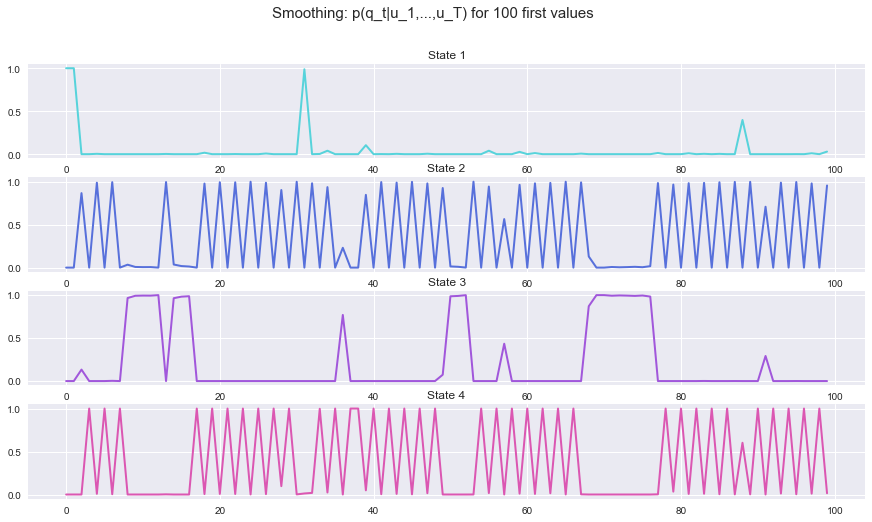

In [155]:
if __name__ == "__main__":


    ## import the data files
    train = np.loadtxt('data/EMGaussian.data')
    test = np.loadtxt('data/EMGaussian.test')

    ## center the data
    # scaler = preprocessing.StandardScaler().fit(train)
    # train = scaler.transform(train)
    # test = scaler.transform(test)

    U = train # npoints=500 x dim=2
    V = test # npoints=500 x dim=2
    K = 4

    ## initialization of the parameters
    (_,mus,sigmas,log_likelihood_gauss,log_likelihood_gauss_test,_) = my_em_gaussian(U, V, K)

    # Transition matrix
    A = np.array([[1/2, 1/6, 1/6, 1/6], [1/6, 1/2, 1/6, 1/6], [1/6, 1/6, 1/2, 1/6], [1/6, 1/6, 1/6, 1/2]])
    pis = (1. / K) * np.ones(K)

    T = 500
    epsilon = 1

    ## compute alpha and beta for all test data .. after similar preprocessing to train data
    logalpha = compute_logalpha(V, A, pis, mus, sigmas)
    logbeta = compute_logbeta(V, A, pis, mus, sigmas)

    ## smoothing proba
    proba_smoothing = smoothing(logbeta, logalpha)

    ## joint proba
    joint_proba = compute_joint_prob(logbeta, logalpha, V, mus, sigmas)

    ## plotting
    proba_smoothing_sample = proba_smoothing[:100, :]

    #f, axarr = plt.subplots(2, 2)
    plt.figure(figsize=(40,40))
    plt.style.use("seaborn")
    
    colors=sns.color_palette("hls", 8)   
            
    # subplots
    f, axes = plt.subplots(4, 1, sharey=True,figsize=(15,8))
    axes[0,].plot(proba_smoothing_sample[:, 0], color=colors[4], linewidth=2)
    axes[0,].set_title('State 1')
    axes[1,].plot(proba_smoothing_sample[:, 1],color=colors[5],  linewidth=2)
    axes[1,].set_title('State 2')
    axes[2,].plot(proba_smoothing_sample[:, 2],color=colors[6],  linewidth=2)
    axes[2,].set_title('State 3')
    axes[3,].plot(proba_smoothing_sample[:, 3],color=colors[7], linewidth=2)
    axes[3,].set_title('State 4')
    
            
    plt.suptitle("Smoothing: p(q_t|u_1,...,u_T) for 100 first values", size=15)
    plt.show()

    

In [149]:
np.shape(axes) 

(4,)

In [44]:
# %run -i em_gauss.py

The log_likelihoods for both GMM and HMM are:
GMM train:  -2327.71567492  GMM test:  -2408.9781747
HMM train:  -1897.78547784  HMM test:  -1955.71522855


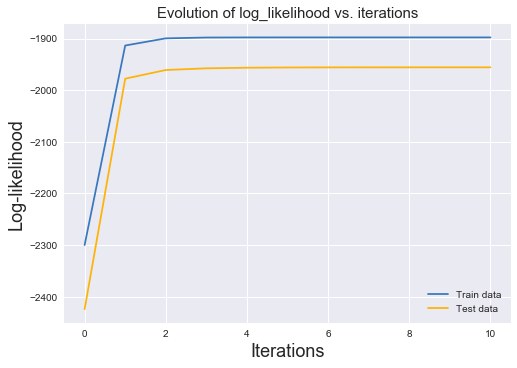

In [137]:
    ## EM algorithm
    A, pis, mus, sigmas, tau, log_likelihood, log_likelihood_test = em_hmm(U, V, K, A, pis, mus, sigmas)
    print( "The log_likelihoods for both GMM and HMM are:" )
    print( "GMM train: ", log_likelihood_gauss, " GMM test: ", log_likelihood_gauss_test )
    print( "HMM train: ", log_likelihood[-1], " HMM test: ", log_likelihood_test[-1] )
    plt.figure()
    C=sns.xkcd_palette(["windows blue","amber"])
    plt.plot(log_likelihood, label="Train data",color=C[0])
    plt.plot(log_likelihood_test, label="Test data",color=C[1])
    plt.title("Evolution of log_likelihood vs. iterations", size=15)
    plt.xlabel("Iterations", size=18)
    plt.ylabel("Log-likelihood", size=18)
    plt.legend()
    plt.show()

    

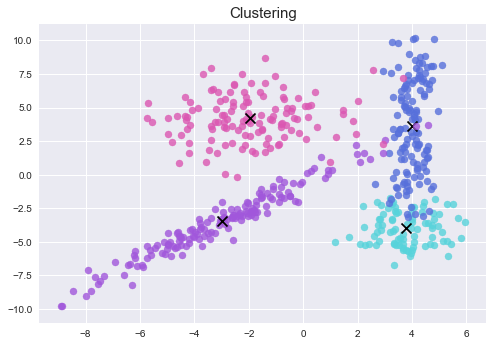

In [138]:
    ## viterbi - most likely sequence
    q_train = viterbi(U, A, pis, mus, sigmas)

    fig, ax = plt.subplots()
    markers = ['o', 's', 'D', '^']
    
    for k in range(K):
        # Train data
        ax.scatter(U[q_train == k, 0], U[q_train == k, 1], marker='o', color=colors[4+k], s=50, alpha=0.8)
        ax.scatter(mus[k, 0], mus[k, 1], marker='x', color='k', s=100)
        ax.set_title("Clustering", size=15)
    plt.show()
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

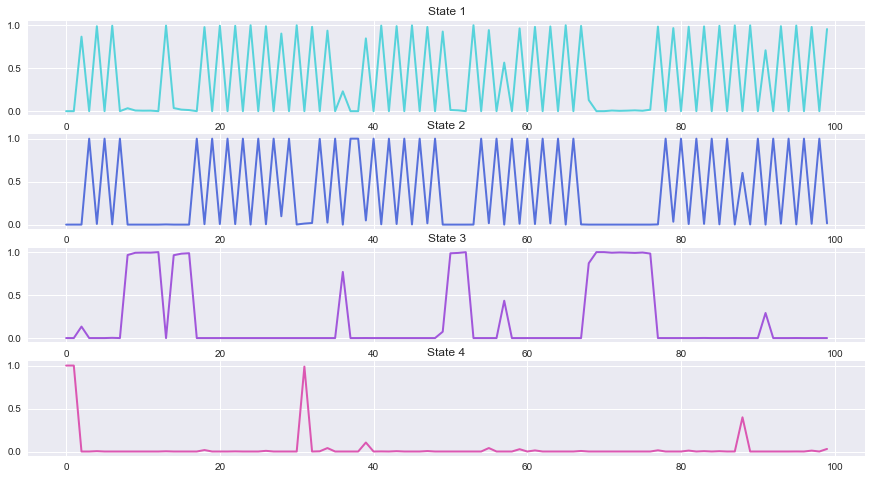

In [154]:
    ## plot p(q_t | u_1,..., u_T)
    logalpha = compute_logalpha(V, A, pis, mus, sigmas)
    logbeta = compute_logbeta(V, A, pis, mus, sigmas)
    proba_smoothing = smoothing(logbeta, logalpha)
    proba_smoothing_sample = proba_smoothing[:100, :]

       
    # subplots
    f, axes = plt.subplots(4, 1, sharey=True,figsize=(15,8))
    axes[0,].plot(proba_smoothing_sample[:, 0], color=colors[4], linewidth=2)
    axes[0,].set_title('State 1')
    axes[1,].plot(proba_smoothing_sample[:, 1],color=colors[5],  linewidth=2)
    axes[1,].set_title('State 2')
    axes[2,].plot(proba_smoothing_sample[:, 2],color=colors[6],  linewidth=2)
    axes[2,].set_title('State 3')
    axes[3,].plot(proba_smoothing_sample[:, 3],color=colors[7], linewidth=2)
    axes[3,].set_title('State 4')
    #plt.suptitle("Smoothing: p(q_t|u_1,...,u_T) for 100 first values", size=15)
    plt.show()

    

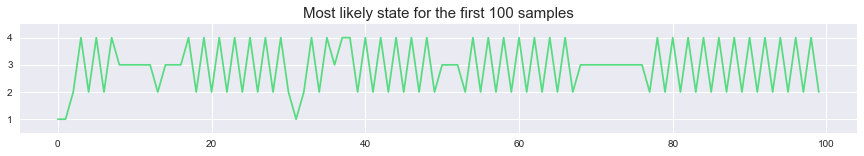

In [163]:
    ## Most likely state
    states = np.argmax(proba_smoothing_sample, axis=1)
    plt.figure(figsize=(15,2))
    plt.plot(range(100), states + 1,color=colors[3])
    plt.ylim((0.5, 4.5))
    plt.title("Most likely state for the first 100 samples", size=15)
    plt.show()

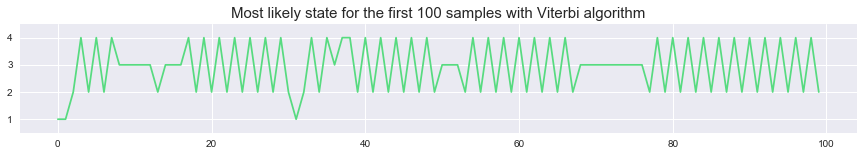

% of difference in states:  0.0 %


In [165]:
    ## viterbi for the test data
    q_test = viterbi(V, A, pis, mus, sigmas)
    plt.figure(figsize=(15,2))
    plt.plot(range(100), q_test[:100] + 1,color=colors[3])
    plt.ylim((0.5, 4.5))
    plt.title("Most likely state for the first 100 samples with Viterbi algorithm", size=15)
    plt.show()
    print( "% of difference in states: ", np.sum(q_test[:100] != states)/100, '%')
